In [1]:
%load_ext autoreload
%autoreload 2

import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm

## PyG integration

<div class="admonition tip highlight">
    <p class="admonition-title">Community contribution</p>
    <p>Curious how one would run this tutorial on <a href="https://www.graphcore.ai/products/ipu">Graphcore IPUs</a>? See this tutorial contributed by <a href="https://github.com/s-maddrellmander">@s-maddrellmander</a>:
    <a href="https://ipu.dev/lDvDHL"><img alt="Run on Gradient" src="https://camo.githubusercontent.com/c9931a1689c37ab786edd3e1e5f59b9a6f7d097628c4689ce2432563ef884524/68747470733a2f2f6173736574732e706170657273706163652e696f2f696d672f6772616469656e742d62616467652e737667"></a></p>
</div>


As seen in the [molfeat integration tutorial](./integration.html), molfeat integrates easily with the PyTorch ecosystem. In this tutorial, we will demonstrate how you can integrate molfeat with [PyG](https://pytorch-geometric.readthedocs.io/en/latest/) for training SOTA GNNs.

To run this tutorial, you will need to install `pytorch-geometric`.

`mamba install -c conda-forge pytorch_geometric`

In [2]:
from molfeat.trans.graph.adj import PYGGraphTransformer
from molfeat.calc.atom import AtomCalculator
from molfeat.calc.bond import EdgeMatCalculator

### Featurizer

We first start by defining our featurizer. We will use the `PYGGraphTransformer` from molfeat with atom and bond featurizers

In [3]:
featurizer = PYGGraphTransformer(
    atom_featurizer=AtomCalculator(), 
    bond_featurizer=EdgeMatCalculator()
)

### Dataset

For the dataset, we will use the `Lipophilicity` dataset (LogD) from MoleculeNet, which contains experimental results of octanol/water distribution coefficient at pH=7.4


In [4]:
df = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv")

In [5]:
df.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


Since training a network with PyTorch requires defining a dataset and dataloader, we can define our custom dataset that will take **(1)** the SMILES, **(2)** the LogD measurement, and **(3)** our molfeat transformer as input to generate the data point we need for model training.

In [6]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric.utils import degree


class DTset(Dataset):
    def __init__(self, smiles, y, featurizer):
        super().__init__()
        self.smiles = smiles
        self.featurizer = featurizer
        self.featurizer.auto_self_loop()
        self.y = torch.tensor(y).unsqueeze(-1).float()
        self.transformed_mols = self.featurizer(smiles)
        self._degrees = None

    @property
    def num_atom_features(self):
        return self.featurizer.atom_dim

    @property
    def num_output(self):
        return self.y.shape[-1]
    
    def __len__(self):
        return len(self.transformed_mols)
    
    @property
    def num_bond_features(self):
        return self.featurizer.bond_dim
    

    @property
    def degree(self):
        if self._degrees is  None:
            max_degree = -1
            for data in self.transformed_mols:
                d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
                max_degree = max(max_degree, int(d.max()))
            # Compute the in-degree histogram tensor
            deg = torch.zeros(max_degree + 1, dtype=torch.long)
            for data in self.transformed_mols:
                d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
                deg += torch.bincount(d, minlength=deg.numel())
            self._degrees = deg
        return self._degrees

    def collate_fn(self, **kwargs):
        # luckily the molfeat featurizer provides a collate functoin for PyG
        return self.featurizer.get_collate_fn(**kwargs)
    
    def __getitem__(self, index):
        return self.transformed_mols[index], self.y[index]

In [7]:
dataset = DTset(df.smiles.values, df.exp.values, featurizer)
generator = torch.Generator().manual_seed(42)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dt, test_dt = torch.utils.data.random_split(dataset, [train_size, test_size], generator=generator)

In [8]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dt, batch_size=BATCH_SIZE, shuffle=True, collate_fn=dataset.collate_fn(return_pair=False))
test_loader = DataLoader(test_dt, batch_size=BATCH_SIZE, shuffle=False, collate_fn=dataset.collate_fn(return_pair=False))


### Network + Training
We are almost ready to go, we just need to define our GNN. Here we use [PNA](https://arxiv.org/abs/2004.05718) as our GNN.

In [9]:
from torch_geometric.nn.models import PNA
from torch_geometric.nn import global_add_pool

DEVICE = "cpu"
NUM_EPOCHS = 10
LEARNING_RATE = 5e-4
PNA_AGGREGATORS = ['mean', 'min', 'max', 'std']
PNA_SCALERS = ['identity', 'amplification', 'attenuation']

In [10]:
model = PNA(in_channels=dataset.num_atom_features, 
                    hidden_channels=128, 
                    num_layers=3,
                    out_channels=dataset.num_output, 
                    dropout=0.1, 
                    act="relu",
                    edge_dim=dataset.num_bond_features,
                    aggregators = PNA_AGGREGATORS,
                    scalers = PNA_SCALERS,
                    deg=dataset.degree,
)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [11]:
# Train
model = model.to(DEVICE).float()
model.train()
with tqdm(range(NUM_EPOCHS)) as pbar:
    for epoch in pbar:
        losses = []
        for data in train_loader:
            data = data.to(DEVICE)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, edge_attr=data.edge_attr)
            out = global_add_pool(out, data.batch)
            loss = F.mse_loss(out.squeeze(), data.y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        pbar.set_description(f"Epoch {epoch} - Loss {np.mean(losses):.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

### Testing

We can now test our model. For the simplicity of this tutorial, no hyper-parameter search and evaluation of the best atom/bond featurization was performed. This inevitably impacts the performance. 

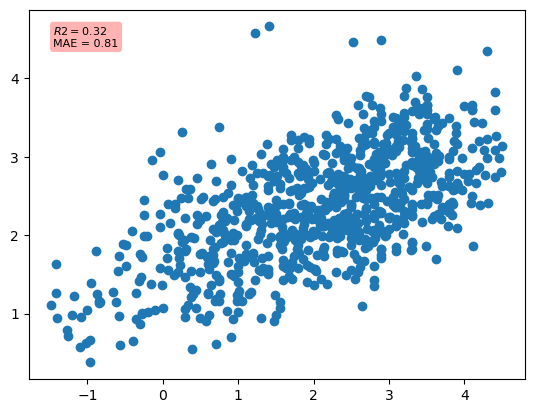

In [12]:
from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib import pyplot as plt

model.eval()
test_y_hat = []
test_y_true = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(DEVICE)
        out = model(data.x, data.edge_index, edge_attr=data.edge_attr)
        out = global_add_pool(out, data.batch)
        test_y_hat.append(out.detach().cpu().squeeze())
        test_y_true.append(data.y)

test_y_hat = torch.cat(test_y_hat).numpy()
test_y_true = torch.cat(test_y_true).numpy()

r2 = r2_score(test_y_true, test_y_hat)
mae = mean_absolute_error(test_y_true, test_y_hat)

plt.scatter(test_y_true, test_y_hat)
_ =plt.gca().annotate(
    "$R2 = {:.2f}$\nMAE = {:.2f}".format(r2, mae), 
    xy=(0.05,0.9),  
    xycoords='axes fraction', 
    size=8,
    bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none")
)